In [11]:
%load_ext lab_black
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from feat import FuelEstimator, MassEstimator
from openap import aero

In [2]:
ac_type = "A320"
flight_profiles = pd.read_pickle("fp.pkl")
me = MassEstimator(ac_type=ac_type)
mass = me.reference_mass

In [4]:
passenger_luggage_mass = 100  # Kg
avg_num_seats = 150  # A320
avg_load_factor = 0.819  # in 2018
m_payload = avg_load_factor * avg_num_seats * passenger_luggage_mass
m_payload

12285.0

In [8]:
from feat import FlightProfileGenerator, FuelEstimator, MassEstimator

fpg = FlightProfileGenerator(ac_type=ac_type, eng_type=None)
fe = FuelEstimator(ac_type=ac_type, eng_type=None)
me = MassEstimator(ac_type=ac_type)

flight_profile = flight_profiles.query("id==0")
oew, tow = me.oew, me.reference_mass
res_cruise = fpg.gen_cruise_for_fuel_reserve()
alt_flight = fpg.gen_flight_for_alternate_fuel()
print(flight_profile.s.iloc[-1] / aero.nm, alt_flight.s.iloc[-1] / aero.nm)

while True:
    f_trip = fe.compute_fuel(flight_profile, mass=tow, last_point=True).fc.item()
    f_cont = f_trip * 0.05
    landing_mass = mass - f_trip
    f_res = fe.compute_fuel(res_cruise, mass=landing_mass, last_point=True).fc.item()
    f_alt = fe.compute_fuel(alt_flight, mass=landing_mass, last_point=True).fc.item()
    m_fuel = f_trip + f_cont + f_res + f_alt
    new_tow = oew + m_payload + m_fuel
    print(f_trip, f_cont, f_res, f_alt, m_fuel, tow, new_tow)
    if abs(tow - new_tow) < 10:
        break
    tow = new_tow

541.5264915146265 258.33672468858316
2476.8965578418165 123.84482789209083 3153.376100334736 1356.9648940055706 7111.082380074214 67380.0 61996.082380074215
2410.5785295408573 120.52892647704287 3153.5932001256338 1357.0124108906264 7041.71306703416 61996.082380074215 61926.71306703416
2409.7589242557615 120.48794621278807 3153.595884586785 1357.0129984308508 7040.855753486186 61926.71306703416 61925.85575348618


541.5264915146265 323.9650428403183


<AxesSubplot:xlabel='s'>

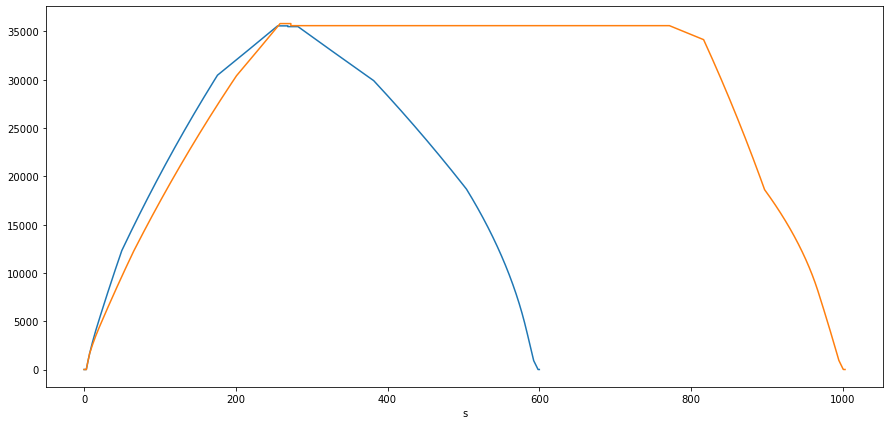

In [11]:
from openap import aero
from openap.traj import Generator

trajgen = Generator(ac=ac_type, eng=None)
traj_alt = trajgen.complete(dt=10, range_cr=0, random=True)
traj_alt = pd.DataFrame.from_dict(traj_alt).assign(id=0)
traj_alt
print(flight_profile.s.iloc[-1] / aero.nm, traj_alt.s.iloc[-1] / aero.nm)

fig, ax = plt.subplots(figsize=(15, 7))
for (_, fp) in traj_alt.assign(h=traj_alt.h / aero.ft, s=traj_alt.s / 1e3).groupby(
    "id"
):
    fp.plot(x="s", y="h", ax=ax, legend=False)
flight_profile.assign(h=flight_profile.h / aero.ft, s=flight_profile.s / 1e3).plot(x="s", y="h", ax=ax, legend=False)